In [1]:
# ==========================================
# STEP 1: GENERATE A TIME SERIES DATASET
# ==========================================

import pandas as pd
import numpy as np

# Create a monthly date range from Jan 2018 to Dec 2025
dates = pd.date_range(start='2018-01-01', end='2025-12-01', freq='MS')

# Create synthetic data with trend + seasonality + noise
np.random.seed(42)
trend = np.linspace(100, 500, len(dates))                  # upward trend
seasonality = 50 * np.sin(2 * np.pi * dates.month / 12)    # yearly cycle
noise = np.random.normal(0, 20, len(dates))                # random variation

# Combine the components to simulate sales
sales = trend + seasonality + noise

# Create DataFrame
df = pd.DataFrame({'Date': dates, 'Sales': sales})
df.set_index('Date', inplace=True)

# Preview the first few rows
print(df.head())

# Save to CSV in your current Jupyter directory
df.to_csv("sales_data.csv")

print("\n✅ Dataset successfully created and saved as 'sales_data.csv'.")


                 Sales
Date                  
2018-01-01  134.934283
2018-02-01  144.746510
2018-03-01  171.374823
2018-04-01  186.393446
2018-05-01  137.159038

✅ Dataset successfully created and saved as 'sales_data.csv'.


In [2]:
# STEP 2: LOAD AND PREVIEW THE DATA
df = pd.read_csv("sales_data.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Display first 10 rows
df.head(10)


,Sales
Date,
2018-01-01,134.934283
2018-02-01,144.746510
2018-03-01,171.374823
2018-04-01,186.393446
2018-05-01,137.159038
2018-06-01,116.369892
2018-07-01,131.847414
2018-08-01,101.521109
2018-09-01,74.294723


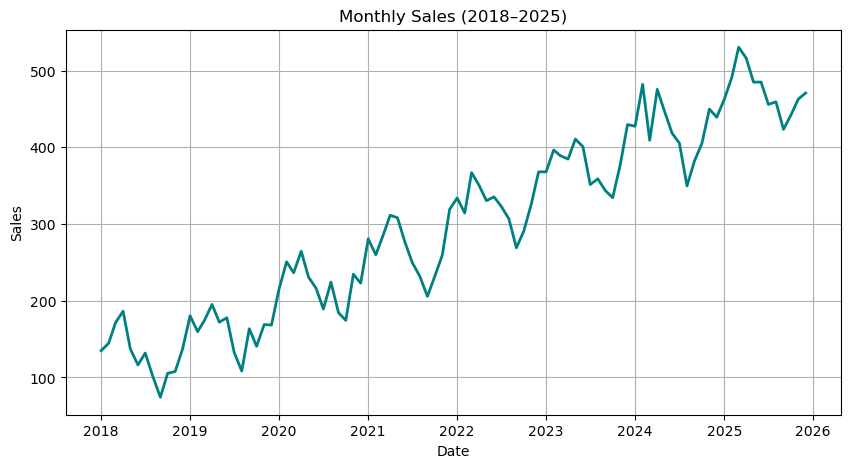

In [4]:
# Visualize your data

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(df.index, df['Sales'], color='teal', linewidth=2)
plt.title("Monthly Sales (2018–2025)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.show()


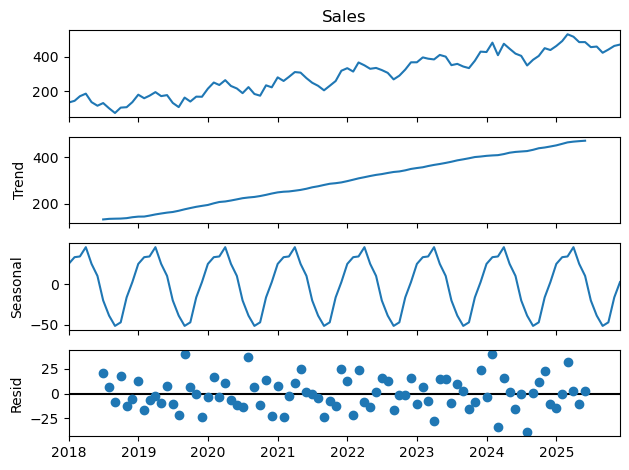

In [5]:
# Decompose the time series (trend, seasonality, residuals)

import statsmodels.api as sm

decomposition = sm.tsa.seasonal_decompose(df['Sales'], model='additive', period=12)
decomposition.plot()
plt.show()


In [6]:
# Check for stationarity (ADF test)

from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Sales'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] > 0.05:
    print("Series is NOT stationary — we’ll difference it next.")
else:
    print("Series is stationary.")


ADF Statistic: 0.26260950086986895
p-value: 0.9755624778638086
Series is NOT stationary — we’ll difference it next.


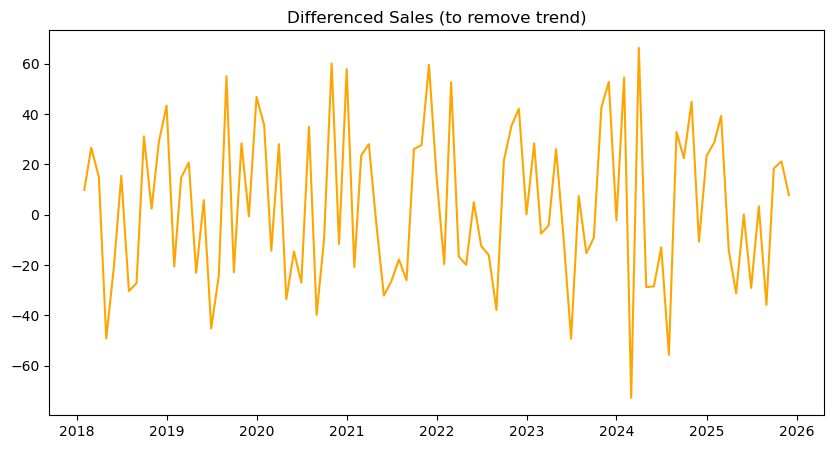

In [7]:
# Make it stationary (differencing)

df['Sales_diff'] = df['Sales'].diff().dropna()

plt.figure(figsize=(10,5))
plt.plot(df.index, df['Sales_diff'], color='orange')
plt.title("Differenced Sales (to remove trend)")
plt.show()


In [8]:
# rerun the ADF test on Sales_diff to confirm it’s stationary.

result = adfuller(df['Sales_diff'].dropna())
print("ADF Statistic (diff):", result[0])
print("p-value (diff):", result[1])


ADF Statistic (diff): -6.343410445938066
p-value (diff): 2.7195757814195193e-08


In [9]:
# Fit an ARIMA model
# I’ll use an ARIMA(1,1,1) as a starting point.

from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df['Sales'], order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())


C:\Anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   96
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -460.197
Date:                Sat, 25 Oct 2025   AIC                            926.395
Time:                        13:39:44   BIC                            934.057
Sample:                    01-01-2018   HQIC                           929.491
                         - 12-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4082      0.750     -0.545      0.586      -1.877       1.061
ma.L1          0.2983      0.793      0.376      0.707      -1.256       1.852
sigma2       944.1862    180.831      5.221      0.0

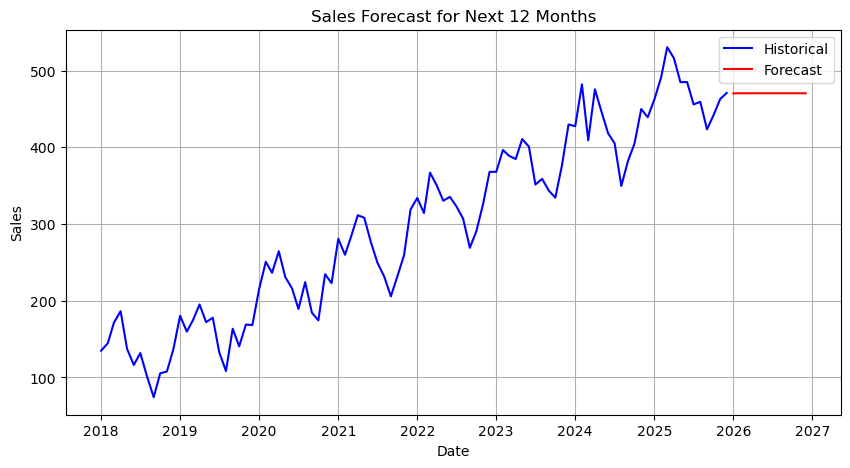

In [12]:
# Forecast the next 12 months

forecast = model_fit.forecast(steps=12)

# Create future dates
future_dates = pd.date_range(df.index[-1], periods=13, freq='MS')[1:]

# Plot forecast vs historical data
plt.figure(figsize=(10,5))
plt.plot(df.index, df['Sales'], label='Historical', color='blue')
plt.plot(future_dates, forecast, label='Forecast', color='red')
plt.title("Sales Forecast for Next 12 Months")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.show()
